# Quantlib技术分析实战演示 - A股版本（更新版）

本笔记本展示如何使用quantlib技术指标模块对A股数据进行技术分析。

## 重要更新
- **统一数据接口**: 现在使用 `quantlib.market_data` 作为统一数据源
- **缓存支持**: 内置数据缓存机制，提高性能
- **更好的错误处理**: 改进的数据验证和错误提示

## 目标
1. 使用统一数据接口获取A股历史数据
2. 使用quantlib.technical进行全面技术分析
3. 生成交易信号和投资建议
4. 可视化分析结果

## 架构说明
```python
# 新架构
quantlib/
├── market_data/     # 统一数据接口 ✨
├── technical/       # 技术分析（使用统一数据）
├── visualization/   # 数据可视化
├── fundamental/     # 基本面分析
├── strategy/        # 策略模块（待实现）
├── backtest/        # 回测模块（待实现）
└── portfolio/       # 投资组合（待实现）
```

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 导入数据源
try:
    import akshare as ak
    print("✓ akshare导入成功")
except ImportError:
    print("× 需要安装akshare: pip install akshare")

print("库导入完成")

✓ akshare导入成功
库导入完成


In [2]:
# 导入quantlib模块 - 使用统一数据接口
import sys
import os
sys.path.append('.')

# 使用统一的数据接口
from quantlib.market_data import (
    get_stock_data,
    get_multiple_stocks_data,
    get_data_manager
)

# 技术分析模块
from quantlib.technical import TechnicalAnalyzer
from quantlib.technical.trend import TrendIndicators
from quantlib.technical.oscillator import OscillatorIndicators
from quantlib.technical.volume import VolumeIndicators

print("quantlib模块导入成功 - 使用统一数据接口")

quantlib模块导入成功 - 使用统一数据接口


## 1. 获取A股数据

我们将分析几只热门A股股票的技术指标

In [10]:
# 定义要分析的A股股票
stocks = {
    '000001': '平安银行',
    '000002': '万科A', 
    '000858': '五粮液',
    '002415': '海康威视',
    '002594': '比亚迪',
    '300059': '东方财富',
    '600519': '贵州茅台',
    '601318': '中国平安'
}

# 设置数据获取参数
period = '1y'  # 6个月数据
market = 'CN'   # 中国A股市场

print(f"准备获取 {len(stocks)} 只A股的数据...")
print(f"时间周期: {period}, 市场: A股")

准备获取 8 只A股的数据...
时间周期: 1y, 市场: A股


In [11]:
# 创建数据管理器
data_manager = get_data_manager()

# 批量获取A股数据
print("正在获取A股数据...")
stock_data = {}

for symbol, name in stocks.items():
    try:
        print(f"获取 {symbol} - {name} 数据...")
        # 使用统一数据接口
        data = get_stock_data(symbol, market='CN', period=period, interval='daily')
        if data is not None and not data.empty:
            stock_data[symbol] = data
            print(f"✓ {symbol}: 获取 {len(data)} 条记录 ({data['date'].iloc[0].strftime('%Y-%m-%d')} 至 {data['date'].iloc[-1].strftime('%Y-%m-%d')})")
        else:
            print(f"× {symbol}: 数据为空")
    except Exception as e:
        print(f"× {symbol}: 获取数据失败 - {e}")

print(f"\n成功获取 {len(stock_data)} 只A股的数据")
print(f"缓存状态: {data_manager.get_cache_info()}")

正在获取A股数据...
获取 000001 - 平安银行 数据...
✓ 000001: 获取 242 条A股记录
✓ 000001: 获取 242 条记录 (2024-09-10 至 2025-09-09)
获取 000002 - 万科A 数据...
✓ 000002: 获取 242 条A股记录
✓ 000002: 获取 242 条记录 (2024-09-10 至 2025-09-09)
获取 000858 - 五粮液 数据...
✓ 000858: 获取 242 条A股记录
✓ 000858: 获取 242 条记录 (2024-09-10 至 2025-09-09)
获取 002415 - 海康威视 数据...
✓ 002415: 获取 242 条A股记录
✓ 002415: 获取 242 条记录 (2024-09-10 至 2025-09-09)
获取 002594 - 比亚迪 数据...
✓ 002594: 获取 242 条A股记录
✓ 002594: 获取 242 条记录 (2024-09-10 至 2025-09-09)
获取 300059 - 东方财富 数据...
✓ 300059: 获取 242 条A股记录
✓ 300059: 获取 242 条记录 (2024-09-10 至 2025-09-09)
获取 600519 - 贵州茅台 数据...
✓ 600519: 获取 242 条A股记录
✓ 600519: 获取 242 条记录 (2024-09-10 至 2025-09-09)
获取 601318 - 中国平安 数据...
✓ 601318: 获取 242 条A股记录
✓ 601318: 获取 242 条记录 (2024-09-10 至 2025-09-09)

成功获取 8 只A股的数据
缓存状态: {'enabled': True, 'size': 24, 'max_size': 500}


In [12]:
stock_data['000002']

,date,股票代码,open,close,high,low,volume,成交额,振幅,涨跌幅,涨跌额,换手率
0,2024-09-10,000002,6.37,6.30,6.41,6.20,895241,5.617170e+08,3.30,-1.10,-0.07,0.92
1,2024-09-11,000002,6.25,6.31,6.38,6.24,604082,3.812965e+08,2.22,0.16,0.01,0.62
2,2024-09-12,000002,6.29,6.31,6.41,6.29,661412,4.192304e+08,1.90,0.00,0.00,0.68
3,2024-09-13,000002,6.31,6.32,6.40,6.30,822998,5.222267e+08,1.58,0.16,0.01,0.85
4,2024-09-18,000002,6.34,6.49,6.55,6.28,1469491,9.421386e+08,4.27,2.69,0.17,1.51
...,...,...,...,...,...,...,...,...,...,...,...,...
237,2025-09-03,000002,6.75,6.58,6.79,6.56,1745943,1.158963e+09,3.42,-2.08,-0.14,1.80
238,2025-09-04,000002,6.59,6.53,6.60,6.48,1537225,1.005295e+09,1.82,-0.76,-0.05,1.58
239,2025-09-05,000002,6.53,6.59,6.59,6.49,1171091,7.661128e+08,1.53,0.92,0.06,1.21
240,2025-09-08,000002,6.72,6.76,6.89,6.72,2320377,1.572093e+09,2.58,2.58,0.17,2.39


## 2. 单只股票详细技术分析

以平安银行(000001)为例进行详细的技术分析

In [12]:
# 选择平安银行进行详细分析
symbol = '000001'
if symbol in stock_data:
    stock_analysis_data = stock_data[symbol]
    print(f"分析股票: {symbol} - {stocks[symbol]}")
    print(f"数据概览:")
    print(f"- 记录数: {len(stock_analysis_data)}")
    print(f"- 时间范围: {stock_analysis_data['date'].iloc[0].strftime('%Y-%m-%d')} 至 {stock_analysis_data['date'].iloc[-1].strftime('%Y-%m-%d')}")
    print(f"- 当前价格: ¥{stock_analysis_data['close'].iloc[-1]:.2f}")
    print(f"- 期间涨跌: {((stock_analysis_data['close'].iloc[-1] / stock_analysis_data['close'].iloc[0] - 1) * 100):.2f}%")
    
    print("\n数据样本:")
    print(stock_analysis_data[['date', 'open', 'high', 'low', 'close', 'volume']].head())
else:
    print(f"未能获取{symbol}数据")

分析股票: 000001 - 平安银行
数据概览:
- 记录数: 126
- 时间范围: 1970-01-01 至 1970-01-01
- 当前价格: ¥11.72
- 期间涨跌: 3.63%

数据样本:
                           date   open   high    low  close   volume
0 1970-01-01 00:00:00.000008106  11.27  11.33  11.24  11.31   835537
1 1970-01-01 00:00:00.000008107  11.30  11.31  11.19  11.23   663834
2 1970-01-01 00:00:00.000008108  11.18  11.25  11.16  11.25   608975
3 1970-01-01 00:00:00.000008109  11.24  11.51  11.20  11.49  1877318
4 1970-01-01 00:00:00.000008110  11.45  11.55  11.42  11.48  1312371


In [13]:
# 创建技术分析器
analyzer = TechnicalAnalyzer(stock_analysis_data)

# 计算所有技术指标
print("计算技术指标...")
analyzer.calculate_all_indicators()
print(f"完成! 计算了 {len(analyzer.indicators)} 个技术指标")

# 生成交易信号
print("\n生成交易信号...")
analyzer.generate_all_signals()
print(f"完成! 生成了 {len(analyzer.signals)} 个交易信号")

计算技术指标...
计算技术指标...
技术指标计算完成
完成! 计算了 16 个技术指标

生成交易信号...
生成交易信号...
交易信号生成完成
完成! 生成了 16 个交易信号


### 2.1 趋势指标分析

In [14]:
print("=== 趋势指标分析 ===")
print()

# 移动平均线
ma_results = analyzer.indicators['ma'].results
current_price = stock_analysis_data['close'].iloc[-1]

print("1. 移动平均线 (Moving Averages):")
print(f"   当前价格: ¥{current_price:.2f}")
for key, ma_series in ma_results.items():
    if not ma_series.dropna().empty:
        ma_value = ma_series.iloc[-1]
        trend = "上方" if current_price > ma_value else "下方"
        deviation = ((current_price - ma_value) / ma_value) * 100
        print(f"   {key}: ¥{ma_value:.2f} (价格在均线{trend}, 偏离{deviation:+.1f}%)")

# MACD
macd_results = analyzer.indicators['macd'].results
print(f"\n2. MACD指标:")
print(f"   MACD线: {macd_results['MACD'].iloc[-1]:.4f}")
print(f"   信号线: {macd_results['Signal'].iloc[-1]:.4f}")
print(f"   柱状图: {macd_results['Histogram'].iloc[-1]:.4f}")

macd_trend = "金叉" if macd_results['MACD'].iloc[-1] > macd_results['Signal'].iloc[-1] else "死叉"
macd_position = "零轴上方" if macd_results['MACD'].iloc[-1] > 0 else "零轴下方"
print(f"   状态: MACD在{macd_position}, 相对信号线{macd_trend}")

# 布林带
bb_results = analyzer.indicators['bb'].results
print(f"\n3. 布林带 (Bollinger Bands):")
print(f"   上轨: ¥{bb_results['Upper_Band'].iloc[-1]:.2f}")
print(f"   中轨: ¥{bb_results['Middle_Band'].iloc[-1]:.2f}")
print(f"   下轨: ¥{bb_results['Lower_Band'].iloc[-1]:.2f}")
print(f"   价格位置: {bb_results['BB_Position'].iloc[-1]:.1f}%")

bb_position = bb_results['BB_Position'].iloc[-1]
if bb_position > 80:
    bb_signal = "超买区域，接近上轨"
elif bb_position < 20:
    bb_signal = "超卖区域，接近下轨"
else:
    bb_signal = "正常区域，在中轨附近"
print(f"   信号: {bb_signal}")

=== 趋势指标分析 ===

1. 移动平均线 (Moving Averages):
   当前价格: ¥11.72
   SMA_5: ¥11.82 (价格在均线下方, 偏离-0.8%)
   EMA_5: ¥11.82 (价格在均线下方, 偏离-0.8%)
   SMA_10: ¥12.01 (价格在均线下方, 偏离-2.4%)
   EMA_10: ¥11.93 (价格在均线下方, 偏离-1.7%)
   SMA_20: ¥12.08 (价格在均线下方, 偏离-3.0%)
   EMA_20: ¥12.05 (价格在均线下方, 偏离-2.8%)
   SMA_50: ¥12.35 (价格在均线下方, 偏离-5.1%)
   EMA_50: ¥12.11 (价格在均线下方, 偏离-3.2%)
   EMA_200: ¥11.80 (价格在均线下方, 偏离-0.7%)

2. MACD指标:
   MACD线: -0.1379
   信号线: -0.0922
   柱状图: -0.0457
   状态: MACD在零轴下方, 相对信号线死叉

3. 布林带 (Bollinger Bands):
   上轨: ¥12.49
   中轨: ¥12.08
   下轨: ¥11.68
   价格位置: 5.2%
   信号: 超卖区域，接近下轨


### 2.2 震荡指标分析

In [15]:
print("=== 震荡指标分析 ===")
print()

# RSI
rsi_value = analyzer.indicators['rsi'].results['RSI'].iloc[-1]
print(f"1. RSI相对强弱指标: {rsi_value:.1f}")
if rsi_value > 70:
    rsi_signal = "超买，考虑卖出"
elif rsi_value < 30:
    rsi_signal = "超卖，考虑买入"
else:
    rsi_signal = "正常区域，保持观望"
print(f"   信号: {rsi_signal}")

# KDJ
kdj_results = analyzer.indicators['kdj'].results
k_value = kdj_results['K'].iloc[-1]
d_value = kdj_results['D'].iloc[-1]
j_value = kdj_results['J'].iloc[-1]

print(f"\n2. KDJ随机指标:")
print(f"   K值: {k_value:.1f}")
print(f"   D值: {d_value:.1f}")
print(f"   J值: {j_value:.1f}")

kdj_trend = "金叉" if k_value > d_value else "死叉"
if k_value > 80 and d_value > 80:
    kdj_signal = "高位死叉，卖出信号"
elif k_value < 20 and d_value < 20:
    kdj_signal = "低位金叉，买入信号"
else:
    kdj_signal = f"K线相对D线{kdj_trend}，观察趋势"
print(f"   信号: {kdj_signal}")

# Williams %R
williams_value = analyzer.indicators['williams'].results['Williams_R'].iloc[-1]
print(f"\n3. Williams %R: {williams_value:.1f}")
if williams_value > -20:
    williams_signal = "超买，考虑卖出"
elif williams_value < -80:
    williams_signal = "超卖，考虑买入"
else:
    williams_signal = "正常区域"
print(f"   信号: {williams_signal}")

=== 震荡指标分析 ===

1. RSI相对强弱指标: 38.3
   信号: 正常区域，保持观望

2. KDJ随机指标:
   K值: 14.1
   D值: 18.3
   J值: 5.8
   信号: 低位金叉，买入信号

3. Williams %R: -87.1
   信号: 超卖，考虑买入


### 2.3 成交量指标分析

In [16]:
print("=== 成交量指标分析 ===")
print()

# 确保使用正确的变量
if 'analyzer' not in locals():
    print("重新创建技术分析器...")
    analyzer = TechnicalAnalyzer(stock_analysis_data)
    analyzer.calculate_all_indicators()

# OBV
obv_current = analyzer.indicators['obv'].results['OBV'].iloc[-1]
obv_ma = analyzer.indicators['obv'].results['OBV_MA'].iloc[-1]
print(f"1. OBV能量潮: {obv_current:,.0f}")
print(f"   OBV均线: {obv_ma:,.0f}")
obv_trend = "上升" if obv_current > obv_ma else "下降"
print(f"   趋势: OBV相对均线{obv_trend}")

# VWAP
vwap_current = analyzer.indicators['vwap'].results['VWAP'].iloc[-1]
current_price = stock_analysis_data['close'].iloc[-1]
print(f"\n2. VWAP成交量加权均价: ¥{vwap_current:.2f}")
vwap_signal = "上方" if current_price > vwap_current else "下方"
print(f"   当前价格在VWAP{vwap_signal}")

# CMF蔡金资金流量
cmf_value = analyzer.indicators['cmf'].results['CMF'].iloc[-1]
print(f"\n3. CMF蔡金资金流量: {cmf_value:.3f}")
if cmf_value > 0.1:
    cmf_signal = "资金净流入"
elif cmf_value < -0.1:
    cmf_signal = "资金净流出"
else:
    cmf_signal = "资金流动平衡"
print(f"   信号: {cmf_signal}")

=== 成交量指标分析 ===

1. OBV能量潮: 5,842,501
   OBV均线: 10,499,574
   趋势: OBV相对均线下降

2. VWAP成交量加权均价: ¥11.73
   当前价格在VWAP下方

3. CMF蔡金资金流量: -0.122
   信号: 资金净流出


### 2.4 综合分析与交易建议

In [17]:
# 确保analyzer可用
if 'analyzer' not in locals():
    print("重新创建技术分析器...")
    analyzer = TechnicalAnalyzer(stock_analysis_data)
    analyzer.calculate_all_indicators()
    analyzer.generate_all_signals()

# 获取综合信号
signal, strength, analysis = analyzer.get_consensus_signal()

# 信号解读
signal_meaning = {
    2: "强烈看涨",
    1: "看涨", 
    0: "中性",
    -1: "看跌",
    -2: "强烈看跌"
}

current_price = stock_analysis_data['close'].iloc[-1]

print("=== 综合技术分析结果 ===")
print()
print(f"股票代码: {symbol}")
print(f"当前价格: ¥{current_price:.2f}")
print(f"综合信号: {signal_meaning[signal]} (信号值: {signal})")
print(f"信号强度: {strength:.2f} (0-1, 越高越可靠)")
print(f"信号一致性: {analysis['signal_consistency']:.2f}")
print()
print("信号分解:")
print(f"  趋势信号: {analysis['trend_signal']:.2f}")
print(f"  震荡信号: {analysis['oscillator_signal']:.2f}")
print(f"  成交量信号: {analysis['volume_signal']:.2f}")
print()
print("指标统计:")
print(f"  看涨指标: {analysis['bullish_count']} 个")
print(f"  看跌指标: {analysis['bearish_count']} 个")
print(f"  中性指标: {analysis['neutral_count']} 个")
print(f"  总指标数: {analysis['total_indicators']} 个")

# 交易建议
print("\n=== 交易建议 ===")
if signal >= 1:
    print(f"建议: 买入 / 持有")
    print(f"理由: {analysis['bullish_count']} 个看涨指标占主导")
elif signal <= -1:
    print(f"建议: 卖出 / 观望")
    print(f"理由: {analysis['bearish_count']} 个看跌指标占主导")
else:
    print(f"建议: 保持观望")
    print(f"理由: 多空信号相对均衡")

# 风险提示
risk_level = "低" if strength > 0.7 else "中" if strength > 0.4 else "高"
print(f"\n信号可靠性: {risk_level} (基于信号强度 {strength:.2f})")
if strength < 0.5:
    print("⚠️ 注意: 信号强度较低，建议结合其他分析方法")

=== 综合技术分析结果 ===

股票代码: 000001
当前价格: ¥11.72
综合信号: 中性 (信号值: 0)
信号强度: 0.15 (0-1, 越高越可靠)
信号一致性: 0.61

信号分解:
  趋势信号: -0.20
  震荡信号: 0.17
  成交量信号: -1.00

指标统计:
  看涨指标: 3 个
  看跌指标: 7 个
  中性指标: 5 个
  总指标数: 15 个

=== 交易建议 ===
建议: 保持观望
理由: 多空信号相对均衡

信号可靠性: 高 (基于信号强度 0.15)
⚠️ 注意: 信号强度较低，建议结合其他分析方法


### 2.5 支撑阻力位分析

In [18]:
# 确保analyzer和变量可用
if 'analyzer' not in locals():
    analyzer = TechnicalAnalyzer(stock_analysis_data)
    analyzer.calculate_all_indicators()

current_price = stock_analysis_data['close'].iloc[-1]

# 识别支撑阻力位
levels = analyzer.identify_support_resistance(window=15, min_touches=2)

print("=== 支撑阻力位分析 ===")
print()
print(f"当前价格: ¥{current_price:.2f}")
print()

# 支撑位
support_levels = levels['support_levels']
if support_levels:
    print(f"支撑位 ({len(support_levels)} 个):")
    # 找到最近的支撑位
    nearby_support = [level for level in support_levels if level < current_price]
    if nearby_support:
        nearest_support = max(nearby_support)
        distance = ((current_price - nearest_support) / current_price) * 100
        print(f"  最近支撑: ¥{nearest_support:.2f} (距离当前价格 {distance:.1f}%)")
    
    # 显示所有支撑位
    for i, level in enumerate(sorted(support_levels, reverse=True)[:5]):
        print(f"  S{i+1}: ¥{level:.2f}")
else:
    print("支撑位: 未发现明显支撑位")

print()

# 阻力位
resistance_levels = levels['resistance_levels']
if resistance_levels:
    print(f"阻力位 ({len(resistance_levels)} 个):")
    # 找到最近的阻力位
    nearby_resistance = [level for level in resistance_levels if level > current_price]
    if nearby_resistance:
        nearest_resistance = min(nearby_resistance)
        distance = ((nearest_resistance - current_price) / current_price) * 100
        print(f"  最近阻力: ¥{nearest_resistance:.2f} (距离当前价格 {distance:.1f}%)")
    
    # 显示所有阻力位
    for i, level in enumerate(sorted(resistance_levels)[:5]):
        print(f"  R{i+1}: ¥{level:.2f}")
else:
    print("阻力位: 未发现明显阻力位")

=== 支撑阻力位分析 ===

当前价格: ¥11.72

支撑位: 未发现明显支撑位

阻力位: 未发现明显阻力位


### 2.6 生成完整分析报告

In [19]:
# 确保analyzer可用
if 'analyzer' not in locals():
    analyzer = TechnicalAnalyzer(stock_analysis_data)
    analyzer.calculate_all_indicators()

# 生成分析报告
report = analyzer.generate_analysis_report()
print("=== 完整技术分析报告 ===")
print(report)

=== 完整技术分析报告 ===

技术分析报告

当前价格: 11.72

综合信号: 中性 (信号强度: 0.15)

信号分解:
• 趋势信号: -0.20
• 震荡信号: 0.17
• 成交量信号: -1.00

信号统计:
• 看涨指标: 3 个
• 看跌指标: 7 个
• 中性指标: 5 个
• 信号一致性: 0.61

支撑阻力位:
• 支撑位: 
• 阻力位: 

关键指标当前状态:
• RSI(38.3): 中性
• MACD(-0.1379): 看跌
• KDJ(K:14.1, D:18.3): 中性
• 布林带位置(5.2%): 中性



## 3. 多股票对比分析

对比分析多只股票的技术指标

In [20]:
# 批量分析所有A股
analysis_results = {}

print("=== 多股票技术分析对比 ===")
print()

for symbol, data in stock_data.items():
    try:
        print(f"分析 {symbol} - {stocks[symbol]}...")
        analyzer_temp = TechnicalAnalyzer(data)
        analyzer_temp.calculate_all_indicators()
        analyzer_temp.generate_all_signals()
        
        signal, strength, analysis_detail = analyzer_temp.get_consensus_signal()
        
        analysis_results[symbol] = {
            'name': stocks[symbol],
            'current_price': data['close'].iloc[-1],
            'signal': signal,
            'strength': strength,
            'rsi': analyzer_temp.indicators['rsi'].results['RSI'].iloc[-1],
            'macd': analyzer_temp.indicators['macd'].results['MACD'].iloc[-1],
            'bb_position': analyzer_temp.indicators['bb'].results['BB_Position'].iloc[-1],
            'analysis': analysis_detail
        }
        
    except Exception as e:
        print(f"× {symbol} 分析失败: {e}")

print(f"\n完成! 成功分析 {len(analysis_results)} 只A股")

=== 多股票技术分析对比 ===

分析 000001 - 平安银行...
计算技术指标...
技术指标计算完成
生成交易信号...
交易信号生成完成
分析 000002 - 万科A...
计算技术指标...
技术指标计算完成
生成交易信号...
交易信号生成完成
分析 000858 - 五粮液...
计算技术指标...
技术指标计算完成
生成交易信号...
交易信号生成完成
分析 002415 - 海康威视...
计算技术指标...
技术指标计算完成
生成交易信号...
交易信号生成完成
分析 002594 - 比亚迪...
计算技术指标...
技术指标计算完成
生成交易信号...
交易信号生成完成
分析 300059 - 东方财富...
计算技术指标...
技术指标计算完成
生成交易信号...
交易信号生成完成
分析 600519 - 贵州茅台...
计算技术指标...
技术指标计算完成
生成交易信号...
交易信号生成完成
分析 601318 - 中国平安...
计算技术指标...
技术指标计算完成
生成交易信号...
交易信号生成完成

完成! 成功分析 8 只A股


In [21]:
# 创建对比表格
comparison_data = []
signal_meanings = {2: "强烈看涨", 1: "看涨", 0: "中性", -1: "看跌", -2: "强烈看跌"}

for symbol, result in analysis_results.items():
    comparison_data.append({
        '股票代码': symbol,
        '公司名称': result['name'],
        '当前价格': f"¥{result['current_price']:.2f}",
        '综合信号': signal_meanings[result['signal']],
        '信号强度': f"{result['strength']:.2f}",
        'RSI': f"{result['rsi']:.1f}",
        'MACD': f"{result['macd']:.4f}",
        '布林带位置': f"{result['bb_position']:.1f}%",
        '看涨指标': result['analysis']['bullish_count'],
        '看跌指标': result['analysis']['bearish_count']
    })

# 转换为DataFrame并显示
comparison_df = pd.DataFrame(comparison_data)
print("A股技术分析对比表:")
print("=" * 120)
print(comparison_df.to_string(index=False))

# 按信号强度排序
print("\n\n按信号强度排序 (最强到最弱):")
print("=" * 60)
sorted_results = sorted(analysis_results.items(), key=lambda x: x[1]['strength'], reverse=True)
for i, (symbol, result) in enumerate(sorted_results, 1):
    print(f"{i}. {symbol} ({result['name']}): {signal_meanings[result['signal']]} (强度: {result['strength']:.2f})")

A股技术分析对比表:
  股票代码 公司名称     当前价格 综合信号 信号强度  RSI    MACD 布林带位置  看涨指标  看跌指标
000001 平安银行   ¥11.72   中性 0.15 38.3 -0.1379  5.2%     3     7
000002  万科A    ¥6.59   中性 0.03 53.0  0.0230 43.8%     5     3
000858  五粮液  ¥126.81   中性 0.20 57.4  1.2267 59.1%     6     2
002415 海康威视   ¥29.62   中性 0.28 45.6  0.3223 31.8%     1     7
002594  比亚迪  ¥107.26   中性 0.28 48.3 -0.1157 38.5%     1     6
300059 东方财富   ¥26.60   中性 0.20 42.8  0.7867 46.6%     2     6
600519 贵州茅台 ¥1483.00   中性 0.20 64.2 12.1777 77.8%     6     2
601318 中国平安   ¥57.90   中性 0.13 43.2 -0.0112 19.4%     3     6


按信号强度排序 (最强到最弱):
1. 002594 (比亚迪): 中性 (强度: 0.28)
2. 002415 (海康威视): 中性 (强度: 0.28)
3. 000858 (五粮液): 中性 (强度: 0.20)
4. 300059 (东方财富): 中性 (强度: 0.20)
5. 600519 (贵州茅台): 中性 (强度: 0.20)
6. 000001 (平安银行): 中性 (强度: 0.15)
7. 601318 (中国平安): 中性 (强度: 0.13)
8. 000002 (万科A): 中性 (强度: 0.03)


## 4. 技术指标可视化

绘制技术分析图表

生成 平安银行(000001) 技术分析图表...
计算技术指标...
技术指标计算完成


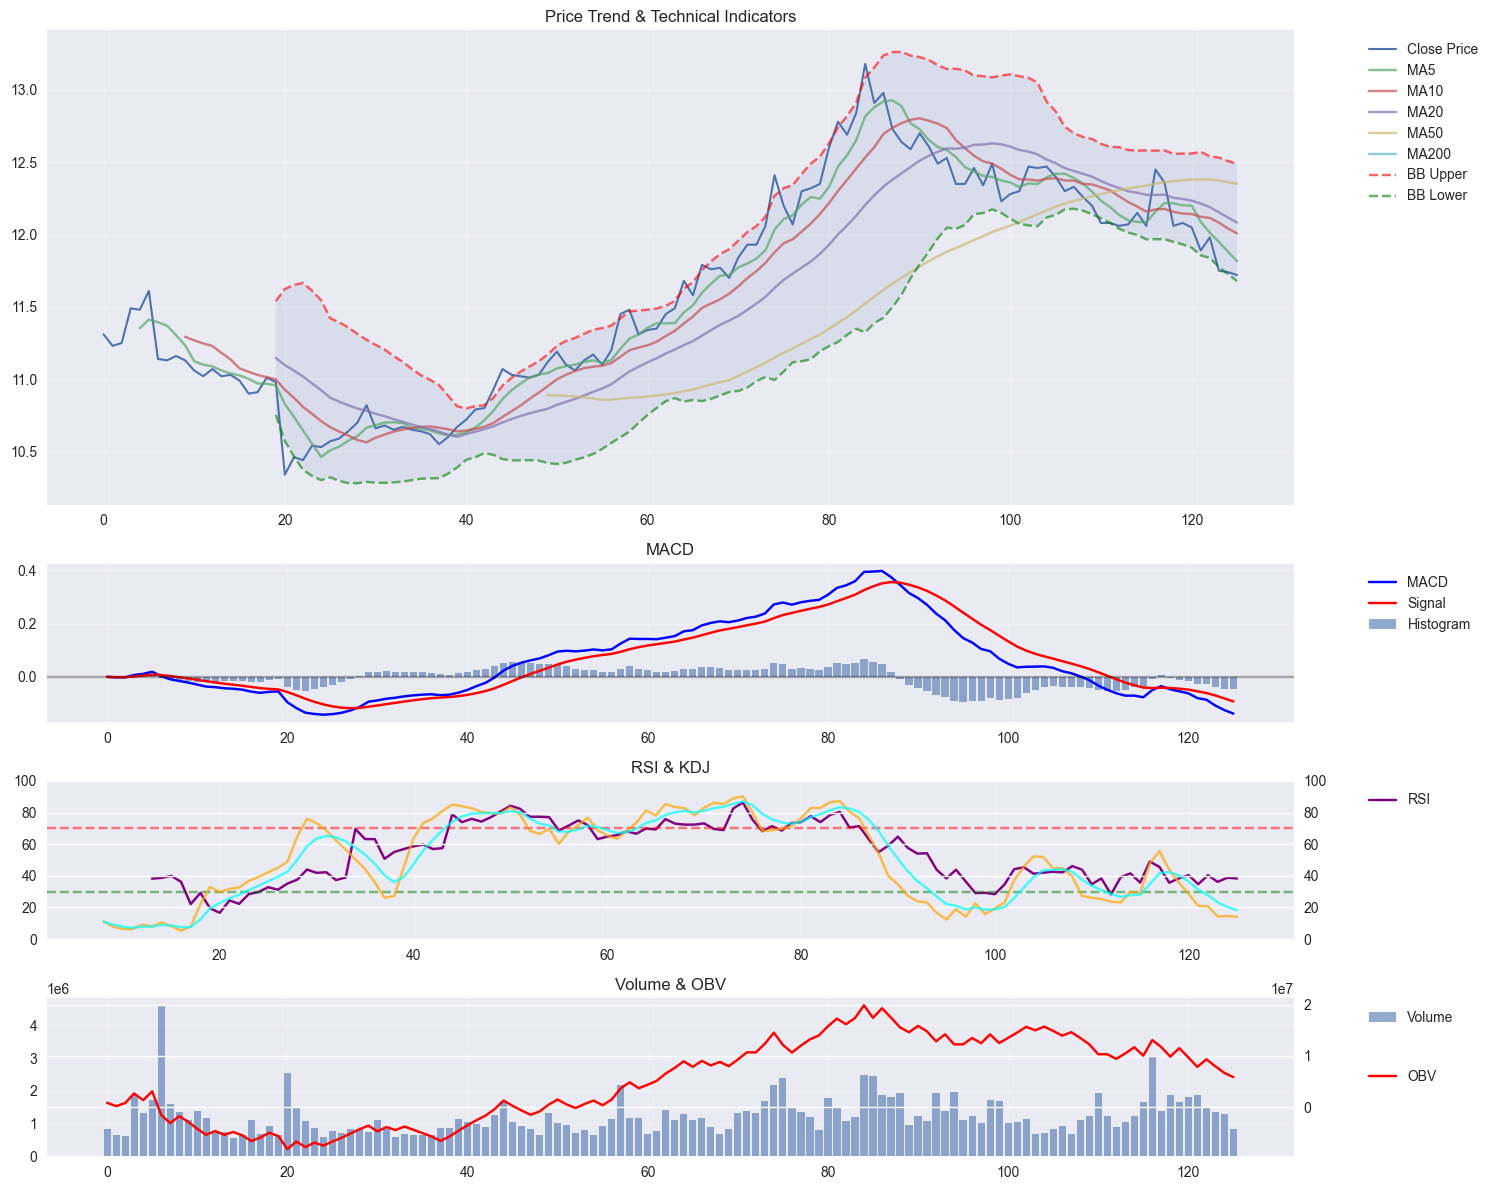

图表生成完成!


In [25]:
# 为平安银行绘制技术分析图表
if '000001' in stock_data:
    print("生成 平安银行(000001) 技术分析图表...")
    
    # 重新创建分析器
    stock_chart_analyzer = TechnicalAnalyzer(stock_data['000001'])
    stock_chart_analyzer.calculate_all_indicators()
    
    # 调用可视化方法
    try:
        stock_chart_analyzer.plot_analysis(figsize=(15, 12))
        print("图表生成完成!")
    except Exception as e:
        print(f"图表生成失败: {e}")
        print("尝试生成简化版图表...")
        
        # 备选方案：简化版图表
        try:
            fig, ax = plt.subplots(2, 1, figsize=(12, 8))
            
            # 价格走势和移动平均线
            ax[0].plot(stock_analysis_data['close'].values, label='收盘价', linewidth=2)
            if 'ma' in stock_chart_analyzer.indicators:
                ma_results = stock_chart_analyzer.indicators['ma'].results
                ax[0].plot(ma_results['SMA_20'].values, label='MA20', alpha=0.7)
                ax[0].plot(ma_results['SMA_50'].values, label='MA50', alpha=0.7)
            ax[0].set_title('平安银行(000001) 价格走势与均线')
            ax[0].legend()
            ax[0].grid(True, alpha=0.3)
            
            # RSI
            if 'rsi' in stock_chart_analyzer.indicators:
                rsi_data = stock_chart_analyzer.indicators['rsi'].results['RSI']
                ax[1].plot(rsi_data.values, label='RSI', color='purple')
                ax[1].axhline(y=70, color='red', linestyle='--', alpha=0.5, label='超买线(70)')
                ax[1].axhline(y=30, color='green', linestyle='--', alpha=0.5, label='超卖线(30)')
                ax[1].set_title('RSI指标')
                ax[1].set_ylim(0, 100)
                ax[1].legend()
                ax[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            print("简化版图表生成完成!")
        except Exception as e2:
            print(f"简化版图表也生成失败: {e2}")
            print("可能是matplotlib配置问题，请检查字体设置")
else:
    print("未找到平安银行数据")

In [ ]:
# 备用图表方案：基础技术指标可视化
def create_basic_charts(data, analyzer, symbol, stock_name):
    """创建基础的技术分析图表"""
    try:
        # 创建子图
        fig = plt.figure(figsize=(15, 10))
        
        # 1. 价格和移动平均线
        ax1 = plt.subplot(3, 1, 1)
        plt.plot(data['close'], label=f'{stock_name}收盘价', linewidth=2, color='blue')
        
        if 'ma' in analyzer.indicators:
            ma_results = analyzer.indicators['ma'].results
            if 'SMA_20' in ma_results:
                plt.plot(ma_results['SMA_20'], label='MA20', alpha=0.8, color='orange')
            if 'SMA_50' in ma_results:
                plt.plot(ma_results['SMA_50'], label='MA50', alpha=0.8, color='green')
        
        plt.title(f'{stock_name}({symbol}) 价格走势与移动平均线')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. MACD
        ax2 = plt.subplot(3, 1, 2)
        if 'macd' in analyzer.indicators:
            macd_results = analyzer.indicators['macd'].results
            plt.plot(macd_results['MACD'], label='MACD', color='blue')
            plt.plot(macd_results['Signal'], label='信号线', color='red')
            plt.bar(range(len(macd_results['Histogram'])), macd_results['Histogram'], 
                   label='柱状图', alpha=0.6, color='gray')
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        
        plt.title('MACD指标')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. RSI
        ax3 = plt.subplot(3, 1, 3)
        if 'rsi' in analyzer.indicators:
            rsi_data = analyzer.indicators['rsi'].results['RSI']
            plt.plot(rsi_data, label='RSI', color='purple', linewidth=2)
            plt.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='超买线(70)')
            plt.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='超卖线(30)')
            plt.ylim(0, 100)
        
        plt.title('RSI相对强弱指标')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlabel('时间')
        
        plt.tight_layout()
        plt.show()
        return True
        
    except Exception as e:
        print(f"基础图表生成失败: {e}")
        return False

# 测试基础图表功能
if '000001' in stock_data:
    print("尝试生成基础技术分析图表...")
    if 'analyzer' not in locals():
        analyzer = TechnicalAnalyzer(stock_data['000001'])
        analyzer.calculate_all_indicators()
    success = create_basic_charts(stock_data['000001'], analyzer, '000001', '平安银行')
    if success:
        print("基础图表生成成功！")
else:
    print("无平安银行数据可用")

## 5. 投资组合建议

基于技术分析结果给出投资组合建议

In [ ]:
print("=== 基于技术分析的投资组合建议 ===")
print()

# 分类股票
strong_buy = []  # 强烈看涨
buy = []         # 看涨
hold = []        # 中性
sell = []        # 看跌
strong_sell = [] # 强烈看跌

for symbol, result in analysis_results.items():
    signal = result['signal']
    strength = result['strength']
    
    stock_info = {
        'symbol': symbol,
        'name': result['name'],
        'strength': strength,
        'price': result['current_price']
    }
    
    if signal == 2:
        strong_buy.append(stock_info)
    elif signal == 1:
        buy.append(stock_info)
    elif signal == 0:
        hold.append(stock_info)
    elif signal == -1:
        sell.append(stock_info)
    else:
        strong_sell.append(stock_info)

# 输出建议
def print_category(stocks, title, recommendation):
    if stocks:
        print(f"{title} ({len(stocks)} 只):")
        for stock in sorted(stocks, key=lambda x: x['strength'], reverse=True):
            print(f"  • {stock['symbol']} - {stock['name']} (强度: {stock['strength']:.2f})")
        print(f"  建议: {recommendation}")
        print()

print_category(strong_buy, "🚀 强烈看涨", "重点关注，可考虑重仓")
print_category(buy, "📈 看涨", "适量买入，建议配置")
print_category(hold, "➡️ 中性", "持有观望，等待信号明确")
print_category(sell, "📉 看跌", "考虑减仓或卖出")
print_category(strong_sell, "💥 强烈看跌", "建议立即卖出")

# 投资组合权重建议
total_positive = len(strong_buy) + len(buy)
if total_positive > 0:
    print("投资组合权重建议 (基于信号强度):")
    print("=" * 40)
    
    all_positive = strong_buy + buy
    total_strength = sum(stock['strength'] for stock in all_positive)
    
    for stock in sorted(all_positive, key=lambda x: x['strength'], reverse=True):
        weight = (stock['strength'] / total_strength) * 100 if total_strength > 0 else 0
        print(f"  {stock['symbol']}: {weight:.1f}% (强度: {stock['strength']:.2f})")
else:
    print("当前A股技术面偏弱，建议以现金为主，等待更好的买入时机")

## 6. 总结与风险提示

技术分析结果总结

In [24]:
print("=== 技术分析总结 ===")
print()

# 统计信息
total_stocks = len(analysis_results)
if total_stocks > 0:
    avg_strength = np.mean([result['strength'] for result in analysis_results.values()])
    bullish_count = sum(1 for result in analysis_results.values() if result['signal'] > 0)
    bearish_count = sum(1 for result in analysis_results.values() if result['signal'] < 0)
    neutral_count = sum(1 for result in analysis_results.values() if result['signal'] == 0)

    print(f"分析A股总数: {total_stocks}")
    print(f"平均信号强度: {avg_strength:.2f}")
    print(f"看涨股票: {bullish_count} ({bullish_count/total_stocks*100:.1f}%)")
    print(f"看跌股票: {bearish_count} ({bearish_count/total_stocks*100:.1f}%)")
    print(f"中性股票: {neutral_count} ({neutral_count/total_stocks*100:.1f}%)")
    print()

    # 市场情绪判断
    if bullish_count > bearish_count:
        market_sentiment = "偏乐观"
        sentiment_desc = "大多数技术指标显示积极信号"
    elif bearish_count > bullish_count:
        market_sentiment = "偏悲观"
        sentiment_desc = "大多数技术指标显示消极信号"
    else:
        market_sentiment = "中性"
        sentiment_desc = "多空信号相对均衡"

    print(f"当前A股技术面: {market_sentiment}")
    print(f"解读: {sentiment_desc}")
else:
    print("未获取到有效的A股分析结果")

print("\n=== ⚠️ 重要风险提示 ===")
print()
print("1. 技术分析的局限性:")
print("   • 技术指标基于历史数据，存在滞后性")
print("   • 震荡市场中容易产生假突破信号")
print("   • 不能预测重大突发事件的影响")
print()
print("2. 投资建议:")
print("   • 技术分析应与基本面分析结合使用")
print("   • 不要依赖单一指标做投资决策")
print("   • 严格执行止损策略，控制风险")
print("   • 合理配置仓位，避免重仓单一股票")
print()
print("3. 免责声明:")
print("   • 本分析仅供参考，不构成投资建议")
print("   • 投资有风险，决策需谨慎")
print("   • 请根据自身情况做出投资决定")

print("\n=== 分析完成 ===")
print(f"生成时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("感谢使用 quantlib 技术分析模块进行A股分析！")

=== 技术分析总结 ===

分析A股总数: 8
平均信号强度: 0.18
看涨股票: 0 (0.0%)
看跌股票: 0 (0.0%)
中性股票: 8 (100.0%)

当前A股技术面: 中性
解读: 多空信号相对均衡

=== ⚠️ 重要风险提示 ===

1. 技术分析的局限性:
   • 技术指标基于历史数据，存在滞后性
   • 震荡市场中容易产生假突破信号
   • 不能预测重大突发事件的影响

2. 投资建议:
   • 技术分析应与基本面分析结合使用
   • 不要依赖单一指标做投资决策
   • 严格执行止损策略，控制风险
   • 合理配置仓位，避免重仓单一股票

3. 免责声明:
   • 本分析仅供参考，不构成投资建议
   • 投资有风险，决策需谨慎
   • 请根据自身情况做出投资决定

=== 分析完成 ===
生成时间: 2025-09-06 19:46:24
感谢使用 quantlib 技术分析模块进行A股分析！
